# Data project

**Project discription** 

In this project we examin the relationship between the expenditure in danish municipalities and the number of books are boaroed during the year. We expect a positive relationship. That being said. We do not claim to have identified a causal relationship.


**Data and variables**

We use data from Statistics Denmark. We use the dataset BIB1 which contains data on libraries, by municipalities and the dataset FOLK1A which contains data on the number of people living in each municipalities 
Udlån 



**Table of contents**<a id='toc0_'></a>    
- 1. [Dataset](#toc1_)    
  - 1.1. [Library data](#toc1_1_)    
  - 1.2. [Municipalities data](#toc1_2_)    
  - 1.3. [Merging dataset](#toc1_3_)    
- 2. [Displaying data](#toc2_)    
  - 2.1. [Loans and expenditures over time](#toc2_1_)    
  - 2.2. [Expenditure and books per capita](#toc2_2_)    


Jeg arbejder på at få det her til at virke 

**Imports and Magic settings**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
plt.style.use('ggplot')

import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from pandasql import sqldf

## 1. <a id='toc1_'></a>[Data set](#toc0_)

### 1.1. Importing Library data

We import the library set to get the variables "Loan. Books" and Expenditure, materials (DKK 1,000).

**Importing data for libraries from DST.** 

In [ ]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'


#Values of the variables  
bib_vars  = Dst.get_variables(table_id = 'BIB1')

#printing the variable types
for id in [ 'BNØGLE', 'Tid']:
    print(id)
    values = bib_vars.loc[bib_vars.id ==id, ['values']].values[0,0]
    for value in values:
        print(f'id = {value["id"]}, text = {value["text"]}')

We import a data set for loans and a dataset for expenditure. We cambine the dataset to a library data set which contains both loans and expenditure, by time and municipalities.

In [ ]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'


#Dictionary of variables of the disired data  (Loan. All materials)
var_loan = {'OMRÅDE': ['*'], 'BNØGLE': [ '15120' ], 'Tid': ['*']}
var_exp = {'OMRÅDE': ['*'], 'BNØGLE': [ '15260'], 'Tid': ['*']}

#Raw dataset 
bib_api_loan = Dst.get_data(table_id = 'BIB1', variables = var_loan)
bib_api_exp = Dst.get_data(table_id = 'BIB1', variables = var_exp)

bib_api_loan.rename     (columns={'INDHOLD': 'loan', 'BNØGLE' : 'slet_var' }, inplace=True)
bib_api_exp.rename      (columns={'INDHOLD': 'exp', 'BNØGLE' : 'slet_var2'}, inplace=True)

#We merge the two parts of the library data on munisipality and year
bib_api = bib_api_loan.merge(bib_api_exp, on=['OMRÅDE', 'TID'])
bib_api.head()


### 1.2. <a id='toc1_2_'></a>[Importing data for population by municipalities](#toc0_)


We import data on the number of people living in each municipalities in the first quarter of each year.

In [ ]:
#Loading the data 
var_pick = {'OMRÅDE': ['*'], 'Tid':['*']}
bef_api = Dst.get_data(table_id='FOLK1A', variables=var_pick)
bef_api.sort_values(by=['OMRÅDE'], inplace=True)

# Keeping only the 1 quarter 
I = bef_api['TID'].str.endswith('Q1')
bef_api_q1 = bef_api[I]

#Renaming the time variable such that it does not include the quarter - for merging later
bef_api_q1 = bef_api_q1.rename(columns={'TID': 'tid_temp'})
bef_api_q1['tid_temp'] = bef_api_q1['tid_temp'].str.slice(stop=4)
bef_api_q1 = bef_api_q1.rename(columns={'tid_temp': 'TID'})

#Variable TID must be an object for merging 
bib_api['TID'] = bib_api['TID'].astype('object')

bef_api_q1.head()

### 1.3. <a id='toc1_3_'></a>[Merging data](#toc0_)

We compaire the datasets

In [38]:
#The datasets
print(f'Library dataset contains data from: {np.min(bib_api.TID.unique())} to {np.max(bib_api.TID)}')
print(f'Municipalities in Library data = {len(bib_api.OMRÅDE.unique())}')

print(f'Bef dataset contains data from: {np.min(bef_api_q1.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Municipalities in Library data = {len(bef_api_q1.OMRÅDE.unique())}')

#Differenses in the datasets
diff_mun = [m for m in bef_api_q1.OMRÅDE.unique() if m not in bib_api.OMRÅDE.unique()]
print (f' Munisipalities in bef and not in Lib: {diff_mun}')


Library dataset contains data from: 2009 to 2021
Municipalities in Library data = 103
Bef dataset contains data from: 2008 to 2023
Municipalities in Library data = 105
 Munisipalities in bef and not in Lib: ['Christiansø', 'Fanø']


For merging and plotting we nees the variables to have the apropriate types

In [ ]:
bib_api['TID'] = bib_api['TID'].astype('object')
bib_api['exp'] = bib_api['exp'].astype('int64')
bib_api['loan'] = bib_api['loan'].astype('int64')
bib_api.head()


print(bef_api_q1.dtypes)
print(bib_api.dtypes)

We merge the datasets, such that we have both the library data and the number of residents in the municipalities using sql.

We calculate the expenditure (in 1 DKK) per capita and the number of borrowed books per capita

In [ ]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

## 2. <a id='toc2_'></a>[Plotting data](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Loans and expenditures over time](#toc0_)

/var/folders/1t/shy39gf516g7nrfy2pmdkn780000gn/T/ipykernel_21674/3229831939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['year'] = pd.to_numeric(subset_df['year'])


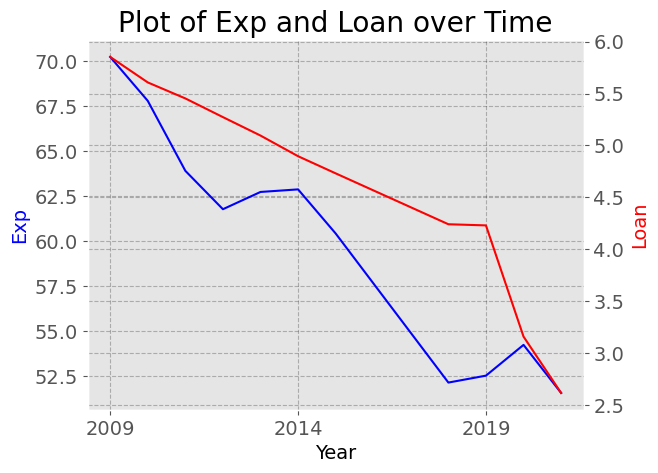

In [36]:
subset_df = df[df['mun'] == 'All Denmark']

# convert 'year' to numeric data type
subset_df['year'] = pd.to_numeric(subset_df['year'])

fig, ax1 = plt.subplots()

# plot 'exp' on the first axis
ax1.plot(subset_df['year'], subset_df['exp_per_cap'], color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Exp', color='b')

# create a twin axis
ax2 = ax1.twinx()

# plot 'loan' on the second axis
ax2.plot(subset_df['year'], subset_df['loan_per_cap'], color='r')
ax2.set_ylabel('Loan', color='r')

# set tick locations and labels for x-axis
xticks = np.arange(subset_df['year'].min(), subset_df['year'].max()+1, 5)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)

plt.title('Plot of Exp and Loan over Time')
plt.show()


### 2.2. <a id='toc2_2_'></a>[Relation between boand books per capita and expenditure per capita](#toc0_)

**Scatter plot**

We now plot the relationship between the expenditure and the number of borrowed books in muisipalities

In [ ]:
#Deleting the Regions and the All of Denmark observations, so as not to count observations twice.
#Deleting municipalities with no expenditure for matirial
df_mun = df[~df['mun'].str.startswith(('Region','All Denmark'))]
df_2 = df=df_mun[df_mun['exp_per_cap'] > 1]


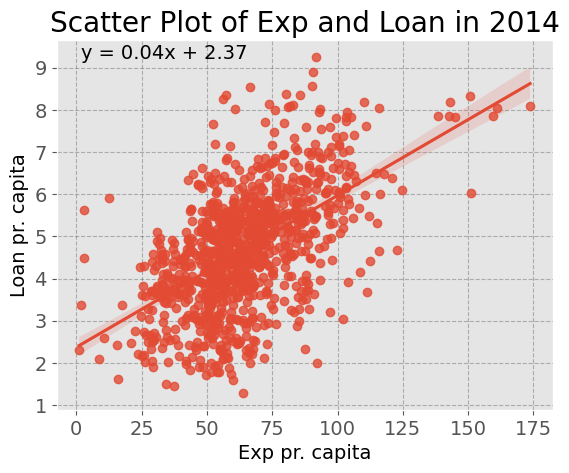

                            OLS Regression Results                            
Dep. Variable:           loan_per_cap   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     278.5
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           4.74e-56
Time:                        21:27:55   Log-Likelihood:                -1851.0
No. Observations:                1132   AIC:                             3706.
Df Residuals:                    1130   BIC:                             3716.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2603      0.092     35.306      

In [39]:
# subset the DataFrame where year is equal to 2014
subset_df = df_2#[df['year'] == '2021']

# create a scatter plot with 'exp' on the x-axis and 'loan' on the y-axis
ax = sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df)

# set plot title and labels
plt.title('Scatter Plot of Exp and Loan in 2014')
plt.xlabel('Exp pr. capita')
plt.ylabel('Loan pr. capita')

# add regression equation
slope, intercept = np.polyfit(subset_df['exp_per_cap'], subset_df['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')

# display the plot
plt.show()


# subset the DataFrame where year is equal to 2014
subset_df = df #[df['year'] == '2021']

# create a regression model with 'exp_per_cap' and 'gdp_per_cap'
X = subset_df[['exp_per_cap']]
y = subset_df['loan_per_cap']
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
print(model1.summary())

# create a regression model with 'exp_per_cap' only
X = subset_df['exp_per_cap']
y = subset_df['loan_per_cap']
X = sm.add_constant(X)
model2 = sm.OLS(y, X).fit()
print(model2.summary())


A regression reviles that there is a small statisticaly significant relationship between the expenditure on matirial per capita, and the number of books borwed per capita. 

If it was a causal relationship an increas in expenditure per capita of DKK 100 (**skriv hvilken stigning det svarer til for gns**) in a given municipalities would cause the average books borrowed per capita to increase by **Der står 2.3 i regresions output og 4 i figuren?**, per year.

# Stop Her

In [ ]:
import seaborn as sns
import statsmodels.api as sm

# subset the DataFrame where year is equal to 2014
subset_df = df[df['year'] == '2014']

# create a scatter plot with 'exp' on the x-axis and 'loan' on the y-axis
ax = sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df)

# set plot title and labels
plt.title('Scatter Plot of Exp and Loan in 2014')
plt.xlabel('Exp pr. capita')
plt.ylabel('Loan pr. capita')

# add regression equation
slope, intercept = np.polyfit(subset_df['exp_per_cap'], subset_df['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')

# display the plot
plt.show()

# subset the DataFrame where year is equal to 2014
subset_df = df[df['year'] == '2018']

# create a scatter plot with 'exp' on the x-axis and 'loan' on the y-axis
ax = sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df)

# set plot title and labels
plt.title('Scatter Plot of Exp and Loan in 2014')
plt.xlabel('Exp pr. capita')
plt.ylabel('Loan pr. capita')

# add regression equation
slope, intercept = np.polyfit(subset_df['exp_per_cap'], subset_df['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')

# display the plot
plt.show()

# subset the DataFrame where year is equal to 2014
subset_df = df [df['year'] == '2014']

# create a regression model with 'exp_per_cap' and 'gdp_per_cap'
X = subset_df[['exp_per_cap']]
y = subset_df['loan_per_cap']
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
print(model1.summary())

# create a regression model with 'exp_per_cap' only
X = subset_df['exp_per_cap']
y = subset_df['loan_per_cap']
X = sm.add_constant(X)
model2 = sm.OLS(y, X).fit()
print(model2.summary())


In [ ]:
q = """
SELECT *
FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()



In [ ]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()


In [ ]:
df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

In [ ]:
exp = df['exp_per_cap'] 
# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.plot(exp)

In [ ]:
df = bib_api.merge(bef_api_q1, on=['OMRÅDE', 'TID'])

In [ ]:
df.head()

Merging using SQL

In [ ]:
case 
    when bib.BNØGLE = 'Loan. Books' then bib.INDHOLD                            = 'loan'
    when bib.BNØGLE = 'Expenditure, materials (DKK 1,000)' then bib.INDHOLD     = 'Expenditure'
end as var_navn,

In [ ]:
q = """
SELECT bef.OMRÅDE, bef.TID, bef.INDHOLD as n, bib.INDHOLD as n_bib, bib.BNØGLE 
FROM bef_api_q1 as bef
INNER JOIN bib_api_loan as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
# Use logical indexing to subset from variable name based on id
#X.loc[X['id'] > 1, ['name']]

bib_api.loc[bib_api['BNØGLE'] == ['BNØGLE']]

In [ ]:
#bef.INDHOLD as n, 
I = bib_api['BNØGLE'] == 'Loan. Books'

bib_api_loan = bib_api[I]

bib_api_loan.head()

#I = bib_api['BNØGLE'] == 'Expenditure, materials (DKK 1,000)' 
#bib_api_exp = bib_api[I]


#bib_api_loan.INDHOLD = loan_n
#INNER JOIN bib_api_loan as bib

In [ ]:
q = """
SELECT bef.OMRÅDE, bef.TID, bef.INDHOLD as n, bib.INDHOLD as n_bib, bib.BNØGLE as test
FROM bef_api_q1 as bef
INNER JOIN bib_api_loan as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
q = """
SELECT df.OMRÅDE, df.TID, df.n, df.n_bib
FROM df as df
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
q = """
SELECT bef.OMRÅDE as municipality, bef.TID as year, bef.INDHOLD as n, bib.INDHOLD as n_bib
FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
Where bib.BNØGLE == 'Loan. Books'
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

z = """
SELECT 
df.municipality, 
df.year, 
df.n, 
df.n_bib,  

bib.INDHOLD as n_exp,
bib.BNØGLE  as skal_vaere_exp


FROM df as df
INNER JOIN bib_api as bib
ON bib.OMRÅDE = df.municipality AND bib.TID = df.year
Where bib.BNØGLE == 'Expenditure, materials (DKK 1,000)' 
"""

df_2 = sqldf(z)

df.head()
#df_2.head()

In [ ]:
I = bib_api['BNØGLE'] == 'Loan. Books'
bib_api_loan = bib_api[I]

q = """
SELECT bef.OMRÅDE as municipality, 
bef.TID as year, 
bef.INDHOLD as n, 

bib_api_loan.INDHOLD as loan 

FROM bef_api_q1 as bef

INNER JOIN bib_api_loan as bib_loan
ON bib_loan.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_loan.TID


"""

# Apply query using pandasql
df = sqldf(q)
df.head()


In [ ]:
I = bib_api['BNØGLE'] == 'Loan. Books'
bib_api_loan = bib_api[I]

q = """
SELECT bef.OMRÅDE as municipality, 
bef.TID as year, 
bef.INDHOLD as n, 

bib_api_loan.INDHOLD as loan, 
bib_api_exp.INDHOLD as exp 

FROM bef_api_q1 as bef

INNER JOIN bib_api_loan as bib_loan
ON bib_loan.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_loan.TID

INNER JOIN bib_api_exp as bib_exp
ON bib_api_exp.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_exp.TID

"""

# Apply query using pandasql
df = sqldf(q)
df.head()


In [ ]:
bib_api.head()

In [ ]:
q = """
SELECT 
bef.OMRÅDE, 
bef.TID, 
bef.INDHOLD as n, 
bib.INDHOLD as exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
where bib.BNØGLE = 'Loan. Books'
"""

# Apply query using pandasql
df = sqldf(q)

print(f'Merged dataset contains data from: {np.min(df.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Merged dataset contains data form Municipalities = {len(df.OMRÅDE.unique())}')
print(f'Merged dataset contains data form Municipalities = {len(df.OMRÅDE.BNØGLE())}')


df.head()


In [ ]:
q = """
SELECT 
bef.OMRÅDE, 
bef.TID, 
bef.INDHOLD as n, 
case 
    when bib.BNØGLE = 'Loan. Books' then 'loan'
    when bib.BNØGLE = 'Expenditure, materials (DKK 1,000)' then 'Expenditure'
end as var_navn

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""
# Apply query using pandasql
df = sqldf(q)

In [ ]:
df.head()